# Installing packages

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import minimize
from scipy.stats.stats import pearsonr  
from scipy import stats
from sklearn.metrics import r2_score
from itertools import combinations

%load_ext rpy2.ipython

/var/folders/ww/jwc_dkyx4_58jw9lnh79r69r0000gn/T/ipykernel_4288/4259127624.py:6: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [2]:
%%R  -w 8 -h 3 #--units in -r 200
##installing packages and setting options for the plots in R

# {r settings, echo=F, message=F, error=F}
knitr::opts_chunk$set(echo = F)
if (!require("pacman")) install.packages("pacman")
pacman::p_load(ggplot2, patchwork, cowplot, tidyverse, devtools, ggrepel, ggh4x, officer, rvg, svglite, install = T)

# # Required on the first run, comment afterward?
devtools::install_github("BlakeRMills/MoMAColors")
library(MoMAColors)

theme_set(theme_cowplot() +
          theme(text = element_text(size=9),
                axis.text = element_text(size=9),
                panel.grid.major.x = element_blank() ,
                panel.grid.major.y = element_line( linewidth=.1, color="black")))

Loading required package: pacman
Skipping install of 'MoMAColors' from a github remote, the SHA1 (6f5d75de) has not changed since last install.
  Use `force = TRUE` to force installation


# Optimized model for english

In [3]:
def get_probs_add(add_cost, mult_cost, f1):
    number_probs = np.zeros(100)
    number_probs[0]=1
    number_probs[1] = f1    
    for i in range(1,100):
        if number_probs[i]==0:
            for j in range(1,i//2 +1):
                number_probs[i] += number_probs[j]*number_probs[i-j]*add_cost  
            for j in range(2, int(np.sqrt(i))+1):
                if i%j==0:
                    number_probs[i] += number_probs[j]*number_probs[i//j]*mult_cost
    return np.log10(number_probs[1:100])

def loss_function(params, target_vector):
    add_cost, mult_cost, f1 = params
    predictions = get_probs_add(add_cost, mult_cost, f1)
    without_10 = [i for i in range(predictions.shape[0]) if (i+1)%10!=0]
    # predictions, target_vector = predictions[without_10], target_vector[without_10]
    return np.sum((predictions - target_vector) ** 2)

In [10]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')

df = data[data.lang.isin(['en'])]
target = np.array(df['log_freq'])
freqs = df.corrected_total_freq
## we define the initial guess for the optimization as what would be 
##the parameters accounting for the first few numbers
## so that the initial guess is in the right neigborhood
initial_guess = [freqs[1]/freqs[0]/freqs[0], freqs[5]/freqs[1]/freqs[2], freqs[0]]
##            = freq(2)/freq(1)^2             , freq(6)/(freq(2)*freq(3))    , freq(1)   
print(f'Inital guess: {initial_guess}')
result = minimize(loss_function, initial_guess, args=(target,), method = 'Nelder-Mead')
best_params = result.x

print("Optimized Parameters:", best_params)
predictions = get_probs_add(*best_params)
R2 = (r2_score(predictions,df.log_freq))
print(f'R2 = {R2}')

numbers = [i+1 for i in range(99)]
preds = {
    'numbers':numbers,
    'log_freq': df.log_freq,
    'predictions':predictions,
    'R2':[R2]*len(numbers)

}
df2 = pd.DataFrame(preds)
df2.to_csv('temp.csv')

Inital guess: [0.0003669579382946686, 0.0003186047933210102, 1565.2685127018156]
Optimized Parameters: [9.40087139e-05 7.28008724e-05 3.30298479e+03]
R2 = 0.8423742612051505


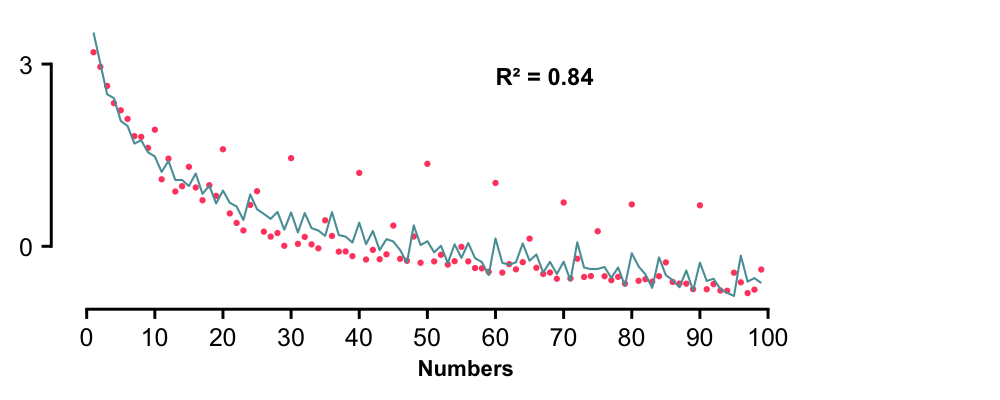

In [8]:
%%R -w 5 -h 2 --units in -r 200 

data <- read.csv('temp.csv')
R2 <- round(data$R2[1],2)
pl_model <- data %>%
    ggplot(aes(x = numbers)) +
    geom_point(aes(y = log_freq, color='line'),size=0.4) +
    geom_line(aes(y = predictions, color='point'), linewidth=0.35) +
    annotate("text", x = 60, y = 2.8, label = paste("R² =", R2), size = 3, hjust = 0, fontface = "bold") +
    theme(legend.position = "none",
            axis.title.y=element_blank(),
            panel.grid.major.y = element_blank(),
            axis.title.x = element_text(face="bold", size=8, hjust=0.44, family='Arial')) +
    labs(x = "Numbers") +
    scale_color_manual(values=moma.colors("Klein")) +
    xlim(1,125) +
    guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
            y = guide_axis_manual(trunc_lower=0, trunc_upper=3, breaks=c(0,3)))

ggsave("plots/4C_model_english_cumulative.svg", pl_model, device='svg',width = 5.2, height = 2.1, units = "in")
pl_model

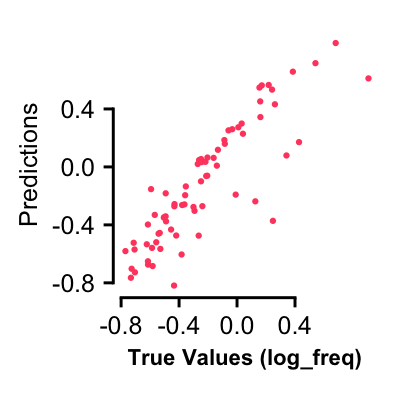

In [6]:
%%R -w 2 -h 2 --units in -r 200 

data <- read.csv('temp.csv')
filtered_data <- data %>%
    filter(numbers >= 21 & numbers <= 99 & numbers %% 10 != 0)

pl_model <- filtered_data %>%
    ggplot(aes(x = log_freq, y = predictions, color='line')) +
    geom_point(size = 0.4) +
    labs(x = "True Values (log_freq)", y = "Predictions") +
    coord_equal() +

    theme(legend.position = "none",
        # axis.title.y=element_blank(),
        panel.grid.major.y = element_blank(),
        axis.title.x = element_text(face="bold", size=8, hjust=0.44, family='Arial')) +
    scale_color_manual(values=moma.colors("Klein")) +
    guides(x = guide_axis_manual(trunc_lower=-0.8, trunc_upper=0.4, breaks=c(-0.8,-0.4,0,0.4)),
            y = guide_axis_manual(trunc_lower=-0.8, trunc_upper=0.4, breaks=c(-0.8,-0.4,0,0.4)))

ggsave("plots/4C_model_english_cumulative_two_words_numbers.svg", pl_model, device='svg',width = 2, height = 2, units = "in")
pl_model



# Checking if the model has the same type of regularities as the data, i.e. same log10 decrease, and importance of divisibility by 2,3,5,10

In [12]:
best_params = (9.40087139e-05, 7.28008724e-05, 3.30298479e+03)

data = pd.read_csv('data_ngram_allLangsPerMilion.csv')
df = data[data.lang.isin(['en'])]

y = get_probs_add(*best_params)

X = np.array(df[['log10', 'mult2', 'mult3','mult5', 'mult10']])
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
R2 = model.rsquared
print(model.pvalues)
print(model.summary())

[5.63771357e-85 5.35106099e-87 3.26976942e-13 1.49964688e-06
 7.66082993e-02 7.77093437e-01]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1259.
Date:                Wed, 15 Jan 2025   Prob (F-statistic):           9.29e-84
Time:                        14:12:39   Log-Likelihood:                 84.988
No. Observations:                  99   AIC:                            -158.0
Df Residuals:                      93   BIC:                            -142.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

# Contribution of different operations to the total frequency

In [7]:
def get_partial_freqs(params):
    add_cost, mult_cost, f1 = params

    number_probs = np.zeros(100)
    number_probs[0]=1
    number_probs[1] = f1  
    partial_freqs = [[] for i in range(100)]
    for i in range(1,100):
        if number_probs[i]==0:
            for j in range(1,i//2 +1):
                number_probs[i] += number_probs[j]*number_probs[i-j]*add_cost  
                partial_freqs[i].append([j,i-j,'add',f'{i-j} + {j}',number_probs[j]*number_probs[i-j]*add_cost])
            for j in range(2, int(np.sqrt(i))+1):
                if i%j==0:
                    number_probs[i] += number_probs[j]*number_probs[i//j]*mult_cost
                    partial_freqs[i].append([j,i//j,'mult', f'{j} x {i//j}', number_probs[j]*number_probs[i//j]*mult_cost])

    return partial_freqs

In [8]:
partial_freqs = get_partial_freqs(best_params)
# n = 34
# df3 = pd.DataFrame(partial_freqs[n], columns=['n1', 'n2', 'operator','whole_op', 'partial_freq'])
# df3.partial_freq = df3.partial_freq.apply(lambda x: x/(df3.partial_freq.sum()))
# df3.to_csv('temp.csv')\
dfs = []
numbers_of_interest = [24,26,34,36]
for number in numbers_of_interest:
    temp_df = pd.DataFrame(partial_freqs[number], columns=['n1', 'n2', 'operator','whole_op', 'partial_freq'])
    temp_df.partial_freq = temp_df.partial_freq.apply(lambda x: x/(temp_df.partial_freq.sum()))
    temp_df['number'] = [number]*len(temp_df)
    dfs.append(temp_df)
df3 = pd.concat(dfs)
df3.to_csv('temp.csv')

In addition: Warning message:
The S3 guide system was deprecated in ggplot2 3.5.0.
ℹ It has been replaced by a ggproto system that can be extended.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


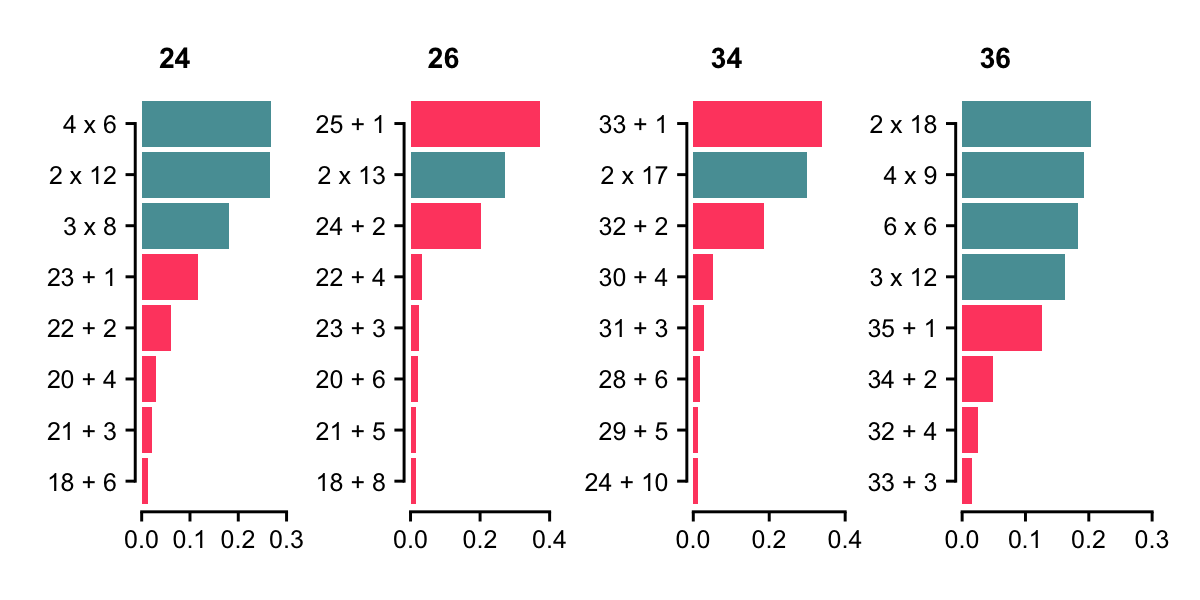

In [9]:
%%R -w 6 -h 3 --units in -r 200 

data <- read.csv('temp.csv')

plots <- list()
numbers_of_interest = c(24,26,34,36)
# Loop through each number in numbers_of_interest
for (n in numbers_of_interest) {
  
  # Filter the data for the current number
  data_filtered <- data %>% filter(number == n) %>% arrange(desc(partial_freq)) %>%  slice_max(partial_freq, n = 8)
  trunc_upper <- 0.1 * ceiling(max(data_filtered$partial_freq) / 0.1)
  break_interval <- ifelse(trunc_upper / 0.1 <= 3.5, 0.1, 0.2)
  # break_interval <- 0.1
  # Generate the plot for this specific number
  p <- data_filtered %>%
    ggplot(aes(y = reorder(whole_op, partial_freq), x = partial_freq, fill = operator)) +
    geom_bar(stat = "identity") +
    # geom_text(aes(x = 0.02, label = whole_op), hjust = 0, size = 3) +  # Position labels inside bars
    labs(y = "Operation", x = "Partial Frequency", title = paste("  ", n)) +
    theme(legend.position = "none",
          axis.title.y = element_blank(),
          # axis.text.y = element_blank(),
          # axis.line.y = element_blank(),
          # axis.ticks.y = element_blank(),
          panel.grid.major.y = element_blank(),
          axis.title.x = element_blank()) +
    scale_fill_manual(values = moma.colors("Klein")) +
    guides(y = guide_axis_manual(trunc_lower = 1, trunc_upper = nrow(data_filtered)),
           x = guide_axis_manual(trunc_lower = 0, trunc_upper = trunc_upper, breaks = seq(0, trunc_upper, break_interval))) 
  
  # Add the plot to the list
  plots[[as.character(n)]] <- p
}

# Combine all plots side-by-side
combined_plot <- wrap_plots(plots, ncol = length(numbers_of_interest))+
  plot_annotation(theme = theme(plot.margin = margin(10, 30, 10, 10)))  # Extra padding

ggsave("plots/5B_operation_contributions_24_26_34_36.svg", combined_plot, device='svg',width = 6, height = 3, units = "in")

# Display the combined plot
combined_plot

# Difference when using multiples of 10 in loss or not

In [15]:
def get_probs_add(add_cost, mult_cost, f1):
    number_probs = np.zeros(100)
    number_probs[0]=1
    number_probs[1] = f1    
    for i in range(1,100):
        if number_probs[i]==0:
            for j in range(1,i//2 +1):
                number_probs[i] += number_probs[j]*number_probs[i-j]*add_cost  
            for j in range(2, int(np.sqrt(i))+1):
                if i%j==0:
                    number_probs[i] += number_probs[j]*number_probs[i//j]*mult_cost
    return np.log10(number_probs[1:100])

def loss_function(params, target_vector):
    add_cost, mult_cost, f1 = params
    predictions = get_probs_add(add_cost, mult_cost, f1)
    without_10 = [i for i in range(predictions.shape[0]) if (i+1)%10!=0]
    # predictions, target_vector = predictions[without_10], target_vector[without_10]
    return np.sum((predictions - target_vector) ** 2)
def loss_function_without_10(params, target_vector):
    add_cost, mult_cost, f1 = params
    predictions = get_probs_add(add_cost, mult_cost, f1)
    without_10 = [i for i in range(predictions.shape[0]) if (i+1)%10!=0]
    predictions, target_vector = predictions[without_10], target_vector[without_10]
    return np.sum((predictions - target_vector) ** 2)



In [18]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')

df = data[data.lang.isin(['en'])]
target = np.array(df['log_freq'])
freqs = df.corrected_total_freq
## we define the initial guess for the optimization as what would be 
##the parameters accounting for the first few numbers
## so that the initial guess is in the right neigborhood
initial_guess = [freqs[1]/freqs[0]/freqs[0], freqs[5]/freqs[1]/freqs[2], freqs[0]]
##            = freq(2)/freq(1)^2             , freq(6)/(freq(2)*freq(3))    , freq(1)   
print(f'Inital guess: {initial_guess}')


result = minimize(loss_function, initial_guess, args=(target,), method = 'Nelder-Mead')
best_params = result.x
print("Optimized Parameters:", best_params)
predictions = get_probs_add(*best_params)
R2 = (r2_score(predictions,df.log_freq))
print(f'R2 = {R2}')


result_without_10 = minimize(loss_function_without_10, initial_guess, args=(target,), method = 'Nelder-Mead')
best_params_without_10 = result_without_10.x
print("Optimized Parameters without 10:", best_params_without_10)
predictions_without_10 = get_probs_add(*best_params_without_10)
R2_without_10 = (r2_score(predictions_without_10,df.log_freq))
print(f'R2 _without_10 = {R2_without_10}')



numbers = [i+1 for i in range(99)]
preds = {
    'numbers':numbers,
    'log_freq': df.log_freq,
    'predictions':predictions,
    'predictions_without_10':predictions_without_10,
    'R2':[R2]*len(numbers)

}
df2 = pd.DataFrame(preds)
df2.to_csv('temp.csv')

Inital guess: [0.0003669579382946686, 0.0003186047933210102, 1565.2685127018156]
Optimized Parameters: [9.40087139e-05 7.28008724e-05 3.30298479e+03]
R2 = 0.8423742612051505
Optimized Parameters without 10: [1.99564601e-04 6.80999626e-05 1.74898018e+03]
R2 _without_10 = 0.8101529644526461


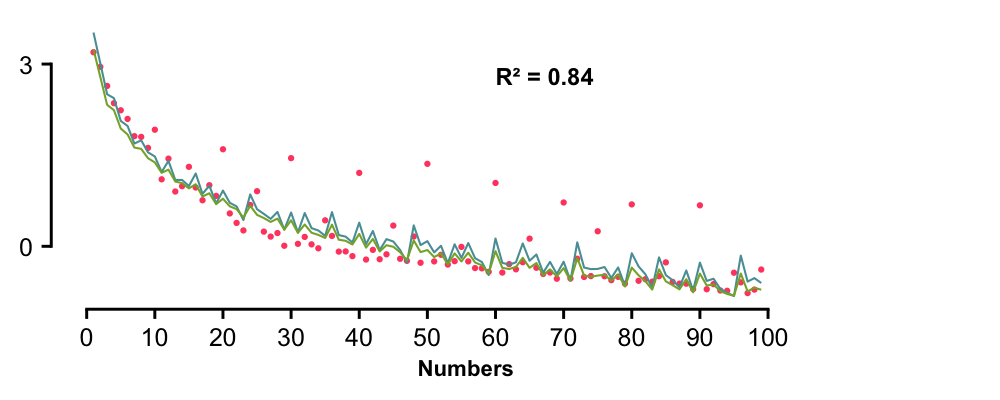

In [25]:
%%R -w 5 -h 2 --units in -r 200 

c1 = moma.colors('Klein',7)[1]
c2 = moma.colors('Klein',7)[2]
c3 = moma.colors('Klein',7)[5]

data <- read.csv('temp.csv')
R2 <- round(data$R2[1],2)
pl_model <- data %>%
    ggplot(aes(x = numbers)) +
    geom_point(aes(y = log_freq),size=0.4, color=c1) +
    geom_line(aes(y = predictions), linewidth=0.35, color=c2) +
    geom_line(aes(y = predictions_without_10), linewidth=0.35, color=c3) +

    annotate("text", x = 60, y = 2.8, label = paste("R² =", R2), size = 3, hjust = 0, fontface = "bold") +
    theme(legend.position = "none",
            axis.title.y=element_blank(),
            panel.grid.major.y = element_blank(),
            axis.title.x = element_text(face="bold", size=8, hjust=0.44, family='Arial')) +
    labs(x = "Numbers") +
    # scale_color_manual(values=moma.colors("Klein")) +
    xlim(1,125) +
    guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
            y = guide_axis_manual(trunc_lower=0, trunc_upper=3, breaks=c(0,3)))

ggsave("plots/S4A_model_english_cumulative.svg", pl_model, device='svg',width = 7, height = 3, units = "in")
pl_model

# Approximation model

In [11]:
w = 0.15
def gaussian(x):
    return(np.exp(-(x**2)))
approx_range = 10
def approx_numbers(n,approx_range):
    return [n-j for j in range(1,approx_range) if n-j>0] + [n+j for j in range(1,approx_range) if n+j<100]


def get_probs_add_approx(add_cost, mult_cost, f1, alpha):
    number_probs = np.zeros(100)
    number_probs[0]=1
    number_probs[1] = f1   
    # number_probs[5] = 300 
    for i in range(1,100):
        if number_probs[i]==0:
            for j in range(1,i//2 +1):
                number_probs[i] += number_probs[j]*number_probs[i-j]*add_cost
            for j in range(2, int(np.sqrt(i))+1):
                if i%j==0:
                    number_probs[i]+= number_probs[j]*number_probs[i//j]*mult_cost

    multiples_10 = [10*i for i in range(1,10)]
    for n in multiples_10:
        prob_appros = []
        for i in approx_numbers(n, approx_range):
            prob_appro = alpha*gaussian((np.log10(n) - np.log10(i))/w)
            number_probs[i] = (1-prob_appro)*number_probs[i]
            print(i)
            print(prob_appro)
            prob_appros.append(prob_appro)
        number_probs[n] =(1+sum(prob_appros))* number_probs[n]
    
    return np.log10(number_probs[1:100])

def loss_function_approx(params, target_vector):
    add_cost, mult_cost, f1, alpha = params
    predictions = get_probs_add_approx(add_cost, mult_cost, f1, alpha)
    return np.sum((predictions - target_vector) ** 2)

In [22]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')

df = data[data.lang.isin(['en'])]
target = np.array(df['log_freq'])
freqs = df.corrected_total_freq
## we define the initial guess for the optimization as what would be 
##the parameters accounting for the first few numbers
## so that the initial guess is in the right neigborhood
initial_guess = [freqs[1]/freqs[0]/freqs[0], freqs[5]/freqs[1]/freqs[2], freqs[0], 1]
##            = freq(2)/freq(1)^2             , freq(6)/(freq(2)*freq(3))    , freq(1)   
print(f'Inital guess: {initial_guess}')
result = minimize(loss_function_approx, initial_guess, args=(target,), method = 'Nelder-Mead')
best_params = result.x

print("Optimized Parameters:", best_params)
predictions = get_probs_add_approx(*best_params)
R2 = (r2_score(predictions,df.log_freq))
print(f'R2 = {R2}')

numbers = [i+1 for i in range(99)]
preds = {
    'numbers':numbers,
    'log_freq': df.log_freq,
    'predictions':predictions,
    'R2':[R2]*len(numbers)

}
df2 = pd.DataFrame(preds)
df2.to_csv('temp.csv')


Inital guess: [0.0003669579382946686, 0.0003186047933210102, 1565.2685127018156, 1]
9
0.9111429631637415
8
0.6587558821990076
7
0.3442361304235893
6
0.11220627702387993
5
0.017818577222213344
4
0.0008778317794350985
3
5.281987552352466e-06
2
3.714019155413683e-10
1
4.989109392794983e-20
11
0.9266780436133335
12
0.7568032341444871
13
0.5615659195560518
14
0.38711242473797
15
0.25204713168047177
16
0.15695810987645384
17
0.09439208863304645
18
0.055233806158911596
19
0.03163497388279459
19
0.9781864219566621
18
0.9111429631637411
17
0.8013893599799825
16
0.6587558821990076
15
0.4996917318976476
14
0.3442361304235888
13
0.21105884111013498
12
0.11220627702387993
11
0.04998320981596157
21
0.980242831377054
22
0.9266780436133343
23
0.8489597870863158
24
0.7568032341444882
25
0.6587558821990076
26
0.5615659195560518
27
0.4700233321341649
28
0.38711242473797
29
0.31432839858420814
29
0.9904118493158377
28
0.9608836115870636
27
0.911142963163742
26
0.8422650338244554
25
0.7568032341444882
24
0

/var/folders/ww/jwc_dkyx4_58jw9lnh79r69r0000gn/T/ipykernel_4288/298457482.py:33: RuntimeWarning: invalid value encountered in log10
  return np.log10(number_probs[1:100])


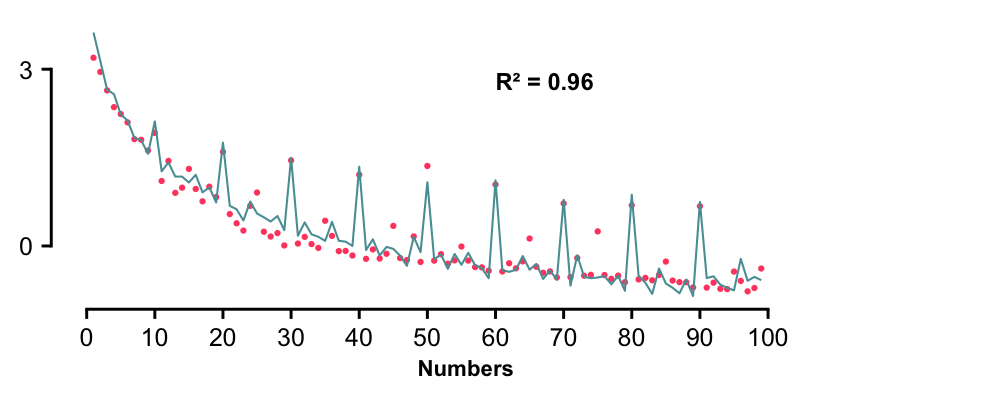

In [24]:
%%R -w 5 -h 2 --units in -r 200 

data <- read.csv('temp.csv')
R2 <- round(data$R2[1],2)
pl_model <- data %>%
    ggplot(aes(x = numbers)) +
    geom_point(aes(y = log_freq, color='line'),size=0.4) +
    geom_line(aes(y = predictions, color='point'), linewidth=0.35) +
    annotate("text", x = 60, y = 2.8, label = paste("R² =", R2), size = 3, hjust = 0, fontface = "bold") +
    theme(legend.position = "none",
            axis.title.y=element_blank(),
            panel.grid.major.y = element_blank(),
            axis.title.x = element_text(face="bold", size=8, hjust=0.44, family='Arial')) +
    labs(x = "Numbers") +
    scale_color_manual(values=moma.colors("Klein")) +
    xlim(1,125) +
    guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
            y = guide_axis_manual(trunc_lower=0, trunc_upper=3, breaks=c(0,3)))

ggsave("plots/5B_model_english_cumul_with_approx.svg", pl_model, device='svg',width = 5.2, height = 2.1, units = "in")
pl_model

# Fitting the model correcting for multiples of 10

In [6]:
def get_probs_add(add_cost, mult_cost, f1):
    number_probs = np.zeros(100)
    number_probs[0]=1
    number_probs[1] = f1    
    for i in range(1,100):
        if number_probs[i]==0:
            for j in range(1,i//2 +1):
                number_probs[i] += number_probs[j]*number_probs[i-j]*add_cost  
            for j in range(2, int(np.sqrt(i))+1):
                if i%j==0:
                    number_probs[i] += number_probs[j]*number_probs[i//j]*mult_cost
    return np.log10(number_probs[1:100])

def loss_function(params, target_vector):
    add_cost, mult_cost, f1 = params
    predictions = get_probs_add(add_cost, mult_cost, f1)
    without_10 = [i for i in range(predictions.shape[0]) if (i+1)%10!=0]
    predictions, target_vector = predictions[without_10], target_vector[without_10]
    return np.sum((predictions - target_vector) ** 2)

def fit_10(predictions, penalty):
    new_predictions = predictions.copy()
    for i in range(len(predictions)):
        if (i+1)%10==0 and i+1!=10:
            new_predictions[i]=new_predictions[(i+1)//10 + 1]*penalty
    return new_predictions

def optimize_penalty(predictions, freqs):
    x = predictions[0:9]
    only_10s = [i for i in range(predictions.shape[0]) if (i+1)%10==0]
    y = freqs[only_10s]
    model = sm.OLS(y, x).fit()
    return  model.params[0]

In [7]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')

df = data[data.lang.isin(['en'])]
target = np.array(df['log_freq'])
freqs = df.corrected_total_freq
## we define the initial guess for the optimization as what would be 
##the parameters accounting for the first few numbers
## so that the initial guess is in the right neigborhood
initial_guess = [freqs[1]/freqs[0]/freqs[0], freqs[5]/freqs[1]/freqs[2], freqs[0]]
##            = freq(2)/freq(1)^2         , freq(6)/(freq(2)*freq(3))  , freq(1), freq(5) 
print(f'Inital guess: {initial_guess}')
result = minimize(loss_function, initial_guess, args=(target,), method = 'Nelder-Mead')
best_params = result.x

print("Optimized Parameters:", best_params)
predictions = get_probs_add(*best_params)

penalty = optimize_penalty(predictions, target)
print(f'Optimized penalty: {penalty}')
predictions_with_10 = fit_10(predictions, penalty)

R2 = (pearsonr(predictions_with_10,df.log_freq).statistic)**2
print(f'R2 = {R2}')

numbers = [i+1 for i in range(99)]
preds = {
    'numbers':numbers,
    'log_freq': df.log_freq,
    'predictions':predictions_with_10,
    'R2':[R2]*len(numbers)

}
df2 = pd.DataFrame(preds)
df2.to_csv('temp.csv')

Inital guess: [0.0003669579382946686, 0.0003186047933210102, 1565.2685127018156]
Optimized Parameters: [1.99564601e-04 6.80999626e-05 1.74898018e+03]
Optimized penalty: 0.5690344673503044
R2 = 0.9544359870112974


In addition: Warning message:
The S3 guide system was deprecated in ggplot2 3.5.0.
ℹ It has been replaced by a ggproto system that can be extended.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


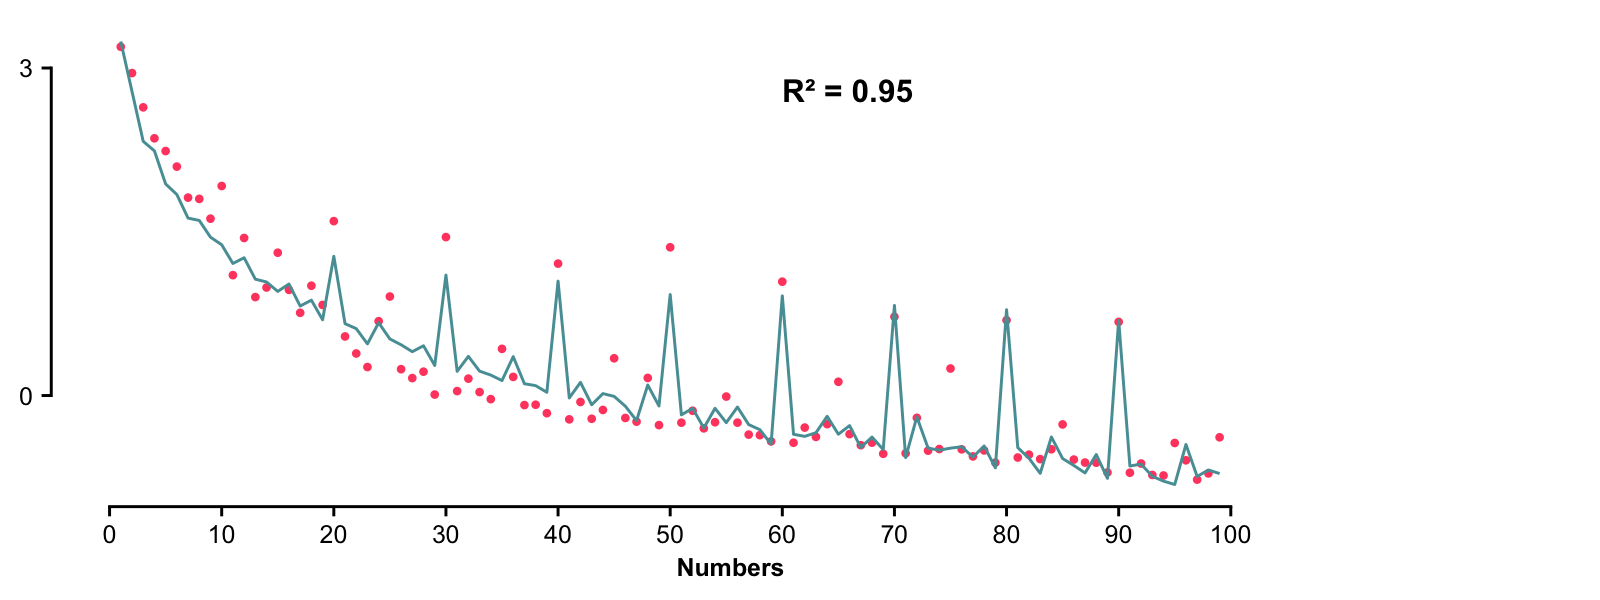

In [8]:
%%R -w 8 -h 3 --units in -r 200 

data <- read.csv('temp.csv')
R2 <- round(data$R2[1],2)
pl_model_with10 <- data %>%
    ggplot(aes(x = numbers)) +
    geom_point(aes(y = log_freq, color='line'),size=0.8) +
    geom_line(aes(y = predictions, color='point'), linewidth=0.5) +
    annotate("text", x = 60, y = 2.8, label = paste("R² =", R2), size = 4, hjust = 0, fontface = "bold") +
    theme(legend.position = "none",
            axis.title.y=element_blank(),
            panel.grid.major.y = element_blank(),
            axis.title.x = element_text(face="bold", size=9, hjust=0.44, family='Arial')) +
    labs(x = "Numbers") +
    scale_color_manual(values=moma.colors("Klein")) +
    xlim(1,125) +
    guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
            y = guide_axis_manual(trunc_lower=0, trunc_upper=3, breaks=c(0,3)))

ggsave("plots/S3B_model_english_with10.svg", pl_model_with10, device='svg',width = 8, height = 3, units = "in")
pl_model_with10

In [9]:
# special case for french and average because there are no values for 97, 98 and 99

def get_probs_add_fr(add_cost, mult_cost, f1):
    number_probs = np.zeros(97)
    number_probs[0] = 1
    number_probs[1] = f1    

    for i in range(1,97):
        if number_probs[i]==0:
            for j in range(1,i//2 +1):
                number_probs[i] = max(number_probs[i],number_probs[j]*number_probs[i-j]*add_cost) 
            for j in range(2, int(np.sqrt(i))+1):
                if i%j==0:
                    number_probs[i]= max(number_probs[i],number_probs[j]*number_probs[i//j]*mult_cost)
    return np.log10(number_probs[1:100])

def loss_function_fr(params, target_vector):
    add_cost, mult_cost, f1 = params
    predictions = get_probs_add_fr(add_cost, mult_cost, f1)
    without_10 = [i for i in range(predictions.shape[0]) if (i+1)%10!=0]
    predictions, target_vector = predictions[without_10], target_vector[without_10]
    return np.sum((predictions - target_vector) ** 2)

In [10]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')
df = data[data.lang.isin(['en'])]
freqs = df.corrected_total_freq
initial_guess = [freqs[1]/freqs[0]/freqs[0], freqs[5]/freqs[1]/freqs[2], freqs[0]]
# we take as an initial guess the one for english because for most languages, 
# f(1)<f(2) which makes this initial guess useless

def fit_model(lang='en'):

    if lang in ['fr', 'mean']:
        get_probs = get_probs_add_fr
        loss = loss_function_fr
        numbers = [i+1 for i in range(96)]
    else:
        get_probs = get_probs_add
        loss = loss_function
        numbers = [i+1 for i in range(99)]

    data = pd.read_csv('data_ngram_allLangsPerMilion.csv')

    df = data[data.lang.isin([lang])]
    target = np.array(df['log_freq'])

    result = minimize(loss, initial_guess, args=(target,), method = 'Nelder-Mead')
    best_params = result.x

    print("Optimized Parameters:", best_params)
    predictions = get_probs(*best_params)

    penalty = optimize_penalty(predictions, target)
    print(f'Optimized penalty: {penalty}')
    predictions_with_10 = fit_10(predictions, penalty)

    R2 = (pearsonr(predictions_with_10,df.log_freq).statistic)**2

    
    preds = {
        'number':numbers,
        'log_freq': df.log_freq,
        'predictions':predictions_with_10,
        'R2':[R2]*len(numbers),
        'lang':[lang]*len(numbers)
    }
    df2 = pd.DataFrame(preds)
    return df2

In [11]:
languages = ['en', 'fr', 'it', 'es', 'de', 'ru', 'mean']
data = pd.concat(fit_model(lang) for lang in languages)
data.to_csv('temp.csv')

Optimized Parameters: [1.99564601e-04 6.80999626e-05 1.74898018e+03]
Optimized penalty: 0.5690344673503044
Optimized Parameters: [3.92207796e-04 1.64411031e-04 1.50034592e+03]
Optimized penalty: 0.557417320058498
Optimized Parameters: [2.08140805e-04 5.90813246e-05 1.65987173e+03]
Optimized penalty: 0.5513668407133756
Optimized Parameters: [1.66225359e-04 9.11659069e-05 2.08544851e+03]
Optimized penalty: 0.6803417631297246
Optimized Parameters: [1.61229318e-04 5.12323451e-05 1.99859373e+03]
Optimized penalty: 0.4189426507174576
Optimized Parameters: [3.94460278e-04 1.29954309e-04 8.68410203e+02]
Optimized penalty: 0.5619374581451129
Optimized Parameters: [6.69961661e-04 2.81960135e-04 8.96788527e+02]
Optimized penalty: 0.5551000834887811


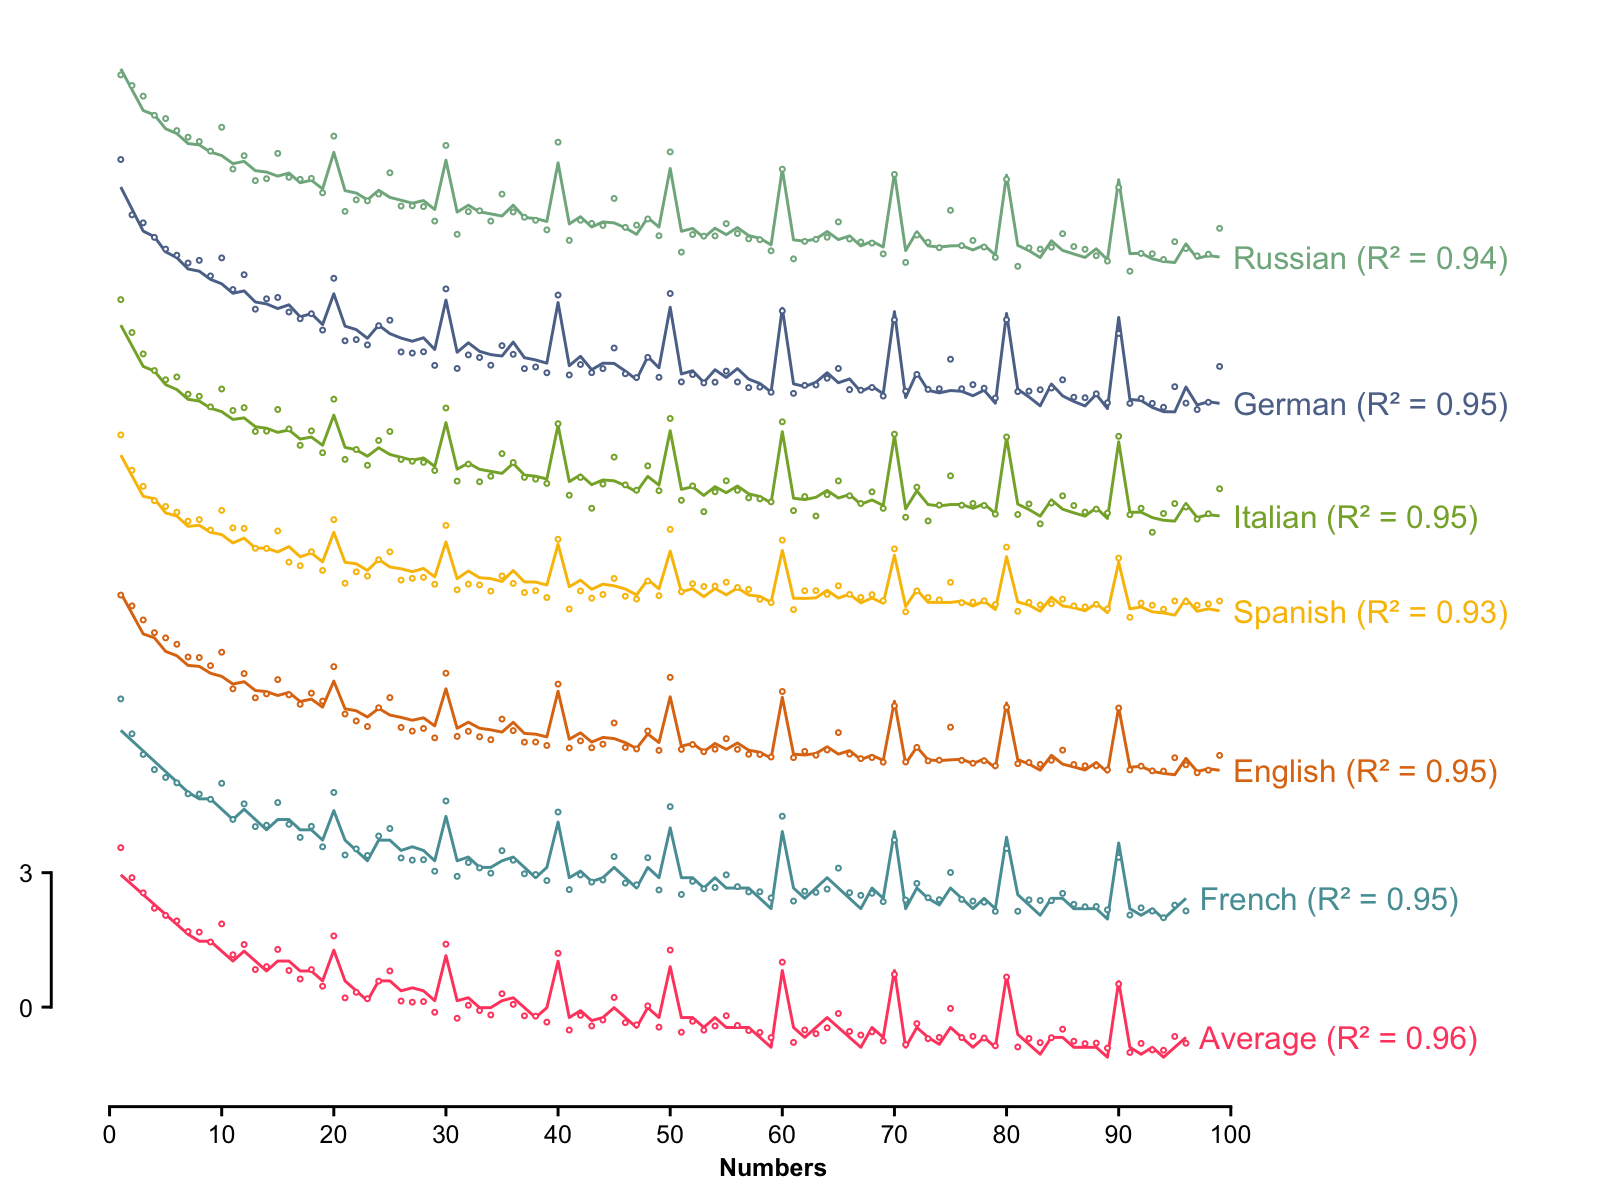

In [12]:
%%R -w 8 -h 6 --units in -r 200 


pl_all_languages <-
  read.csv("temp.csv") %>%
  mutate(nicelang =
         case_when(
          lang == "mean" ~ "Average",
          lang == "fr" ~ "French",
          lang == "en" ~ "English",
          lang == "it" ~ "Italian",
          lang == "de" ~ "German",
          lang == "es" ~ "Spanish",
          lang == "ru" ~ "Russian",
          
          )) %>%
  mutate(nicelang = factor(nicelang, levels=c('Average',"French", "English", "Spanish", "Italian", "German", "Russian"))) %>%
  filter(number > 0, number < 100) %>%
  group_by(nicelang) %>%
  mutate(label = if_else(number == max(number), 
                         paste0(nicelang, " (R² = ", round(R2, 2), ")"), 
                         NA_character_)) %>%
  ungroup %>%
  ggplot(aes(x = number, y = 3*(as.numeric(nicelang)-1) + predictions, color=nicelang, group=nicelang)) +
  geom_line(linewidth=0.5) +
  geom_point(aes(y = 3*(as.numeric(nicelang)-1) + log_freq), size = 0.5, shape = 21, fill = "white") +  # Scatter plot for log_freq

  geom_text_repel(aes(label = label), size=4, nudge_x = 4, na.rm = TRUE) +
  theme(legend.position = "none",
        axis.title.y=element_blank(),
        panel.grid.major.y = element_blank(),
        axis.title.x = element_text(face="bold", size=9, hjust=0.47, family='Arial')) +
  labs(x = "Numbers") +

  scale_color_manual(values=moma.colors("Klein")) +
  xlim(1,125) +
  guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
         y = guide_axis_manual(trunc_lower=0, trunc_upper=3, breaks=c(0,3)))
ggsave(filename = "plots/S3_all_languages_fitted.svg", device='svg', plot = pl_all_languages, width = 8, height = 6)
pl_all_languages